Our aim is to reproduce an example from the paper:

[Inferring single-trial neural population dynamics using sequential auto-encoders](https://www.nature.com/articles/s41592-018-0109-9)

We will generate trajectories from a latent Lorentz attractor and apply LFADS to recover the latent dynamic. Instead of using the original code (https://lfads.github.io/lfads-run-manager/) we will use tensorflow 2.

In [1]:
# Maplotlib and numpy 
import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import scipy.io
# Tensorflow
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import funs
# Lorenz attractor
from Lorenz_Attractor import sample_traj_lorenz

# Sample from latent Lorenz attractor:


In [2]:
Time = 500
neuron_num = 30
traj = sample_traj_lorenz(T = Time,speed_up = 4,initial_offset = 10000)
datax = scipy.io.loadmat("xtrain_hati20.mat")
y_data = datax["yy"] 
traj = scipy.io.loadmat("trj_hati.mat")
traj = traj["xxhati"]

[[-0.09136076  6.9178786  -0.251625   ... -0.09785359 -0.31170198
  -0.23226742]
 [-0.09136076  1.2575387  -0.251625   ...  1.9694756  -0.31170198
  -0.23226742]
 [-0.09136076  6.9178786  -0.251625   ...  0.59125614 -0.31170198
  -0.23226742]
 ...
 [-0.09136076  6.9178786  -0.251625   ... -0.09785359 -0.31170198
  -0.23226742]
 [-0.09136076  0.31414884 -0.251625   ...  0.59125614 -0.31170198
  -0.23226742]
 [-0.09136076 -0.15754612 -0.251625   ...  2.6585853  -0.31170198
  -0.23226742]]


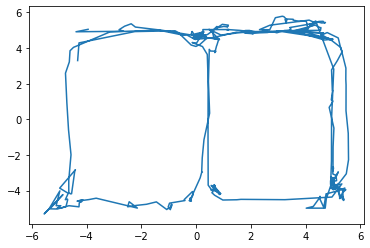

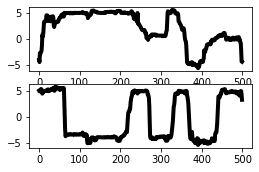

In [3]:
factor_dim = 2
Factor = np.random.randn(factor_dim,neuron_num)

NRep=1
output = np.zeros((NRep,Time,neuron_num))

for i in range(NRep):
    output[i,:,:] = y_data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj[:,0],traj[:,1])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    
output = output.astype('float32')

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)
print(output[0])

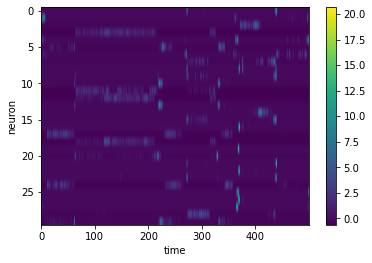

In [4]:
plt.figure()
plt.imshow(output[0,:,:].T,aspect='auto')
plt.xlabel('time')
plt.ylabel('neuron')
plt.colorbar()
plt.show()

In [5]:
# Create Tensorflow Dataset
dataset = tf.data.Dataset.from_tensor_slices((output))
#print(dataset)
#dataset = dataset.shuffle(20, reshuffle_each_iteration=True)

# Autoencoder Model

In [6]:
tf.keras.backend.clear_session()

In [7]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
class Encoder(tf.keras.layers.Layer):
    """Maps Trajectory to a triplet (z_mean, z_log_var, z)."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 name='encoder',
                 **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)        
        self.bidir_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(num_gru_unit,return_sequences=False), 
                                                       input_shape=(sequence_length, num_input_neuron))
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        self.sampling = Sampling()
        
    def call(self, inputs):
        x = self.bidir_gru(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [9]:
class Decoder(tf.keras.layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""
    def __init__(self,
                 latent_dim=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=2,
                 name='decoder',
                 **kwargs):
        self.sequence_length = sequence_length
        super(Decoder, self).__init__(name=name, **kwargs)
        self.recurrent_decoder = tf.keras.layers.GRU(latent_dim,return_sequences=True)#,use_bias=False)
        self.linear_bottleneck = tf.keras.layers.Dense(num_factor, activation=None)
        self.dense_output = tf.keras.layers.Dense(64, activation='relu')
        self.dense_output2 = tf.keras.layers.Dense(num_input_neuron)
        self.latent_dim=latent_dim
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        null_input = tf.zeros([batch_size,self.sequence_length,self.latent_dim])
        decoder_output = self.recurrent_decoder(null_input, initial_state=inputs)
        x = self.linear_bottleneck(decoder_output)
        xo = self.dense_output(x)
        xo = self.dense_output2(xo)
        return xo, x

In [10]:
class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=2,
                 name='autoencoder',
                 **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder(latent_dim=latent_dim,num_gru_unit=num_gru_unit,sequence_length=sequence_length,
                               num_input_neuron=num_input_neuron)
        self.decoder = Decoder(latent_dim=latent_dim, sequence_length=sequence_length,
                              num_input_neuron=num_input_neuron,num_factor=num_factor)
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)[0]
        # Add KL divergence regularization loss.
        kl_loss = - 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed
    def latent(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        latent = self.decoder(z)[1]
        return latent

In [11]:
BATCH_SIZE = 64
batched_dataset = dataset.batch(BATCH_SIZE)

In [12]:
vae = VariationalAutoEncoder(latent_dim=64,
                             num_gru_unit=128,
                             sequence_length=Time,
                             num_input_neuron=neuron_num,
                             num_factor=2)

# Train Model

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2,clipvalue=200)
mse_loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()

#### Linearly scheduling on the Kullback–Leibler divergence penalty:

We use a linearly increasing schedule on the Kullback–Leibler divergence penalty (as suggested [here](https://arxiv.org/pdf/1511.06349.pdf)) so that the optimization does not quickly (and pathologically) set the Kullback–Leibler divergence to 0


In [14]:
KL_penalty = np.linspace(0,1,4)

In [ ]:
epochs = 800

for i,kl_ in enumerate(KL_penalty):
    
    # Iterate over epochs.
    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))

        # Iterate over the batches of the dataset.
        for step, x_batch_train in enumerate(batched_dataset):
            with tf.GradientTape() as tape:
                reconstructed = vae(x_batch_train)
                # Compute reconstruction loss
                loss = mse_loss_fn(x_batch_train, reconstructed)
                loss += kl_*sum(vae.losses)  # Add KLD regularization loss

            grads = tape.gradient(loss, vae.trainable_weights)
            optimizer.apply_gradients(zip(grads, vae.trainable_weights))
            loss_metric(loss)

            if step % 100 == 0:
                print('step %s: mean loss = %s' % (step, loss_metric.result().numpy()))

Start of epoch 0
step 0: mean loss = 0.99999106
Start of epoch 1
step 0: mean loss = 1.001384
Start of epoch 2
step 0: mean loss = 1.0010993
Start of epoch 3
step 0: mean loss = 1.000626
Start of epoch 4
step 0: mean loss = 1.0001563
Start of epoch 5
step 0: mean loss = 0.9986537
Start of epoch 6
step 0: mean loss = 1.0005316
Start of epoch 7
step 0: mean loss = 0.9992617
Start of epoch 8
step 0: mean loss = 0.99885726
Start of epoch 9
step 0: mean loss = 0.9983597
Start of epoch 10
step 0: mean loss = 0.99787426
Start of epoch 11
step 0: mean loss = 0.9972678
Start of epoch 12
step 0: mean loss = 0.99677646
Start of epoch 13
step 0: mean loss = 0.99587476
Start of epoch 14
step 0: mean loss = 0.99506676
Start of epoch 15
step 0: mean loss = 0.9941689
Start of epoch 16
step 0: mean loss = 0.9931782
Start of epoch 17
step 0: mean loss = 0.99223655
Start of epoch 18
step 0: mean loss = 0.9913554
Start of epoch 19
step 0: mean loss = 0.9907156
Start of epoch 20
step 0: mean loss = 0.99003

step 0: mean loss = 0.9531338
Start of epoch 170
step 0: mean loss = 0.953022
Start of epoch 171
step 0: mean loss = 0.95291287
Start of epoch 172
step 0: mean loss = 0.9528029
Start of epoch 173
step 0: mean loss = 0.9526976
Start of epoch 174
step 0: mean loss = 0.952591
Start of epoch 175
step 0: mean loss = 0.9524845
Start of epoch 176
step 0: mean loss = 0.9523816
Start of epoch 177
step 0: mean loss = 0.9522764
Start of epoch 178
step 0: mean loss = 0.95217276
Start of epoch 179
step 0: mean loss = 0.9520718
Start of epoch 180
step 0: mean loss = 0.9519694
Start of epoch 181
step 0: mean loss = 0.9518672
Start of epoch 182
step 0: mean loss = 0.95176816
Start of epoch 183
step 0: mean loss = 0.9516697
Start of epoch 184
step 0: mean loss = 0.95156974
Start of epoch 185
step 0: mean loss = 0.9514753
Start of epoch 186
step 0: mean loss = 0.9513788
Start of epoch 187
step 0: mean loss = 0.9512814
Start of epoch 188
step 0: mean loss = 0.9511908
Start of epoch 189
step 0: mean loss 

step 0: mean loss = 0.94314116
Start of epoch 337
step 0: mean loss = 0.94311196
Start of epoch 338
step 0: mean loss = 0.9430738
Start of epoch 339
step 0: mean loss = 0.9430494
Start of epoch 340
step 0: mean loss = 0.94301766
Start of epoch 341
step 0: mean loss = 0.94299513
Start of epoch 342
step 0: mean loss = 0.94297093
Start of epoch 343
step 0: mean loss = 0.9429362
Start of epoch 344
step 0: mean loss = 0.9429051
Start of epoch 345
step 0: mean loss = 0.94287324
Start of epoch 346
step 0: mean loss = 0.9428422
Start of epoch 347
step 0: mean loss = 0.94280815
Start of epoch 348
step 0: mean loss = 0.94277173
Start of epoch 349
step 0: mean loss = 0.94273734
Start of epoch 350
step 0: mean loss = 0.9427007
Start of epoch 351
step 0: mean loss = 0.94266737
Start of epoch 352
step 0: mean loss = 0.9426336
Start of epoch 353
step 0: mean loss = 0.9425979
Start of epoch 354
step 0: mean loss = 0.94256693
Start of epoch 355
step 0: mean loss = 0.9425312
Start of epoch 356
step 0: m

step 0: mean loss = 0.91959924
Start of epoch 503
step 0: mean loss = 0.91937786
Start of epoch 504
step 0: mean loss = 0.9191674
Start of epoch 505
step 0: mean loss = 0.91900015
Start of epoch 506
step 0: mean loss = 0.91880447
Start of epoch 507
step 0: mean loss = 0.91860163
Start of epoch 508
step 0: mean loss = 0.91838807
Start of epoch 509
step 0: mean loss = 0.91818607
Start of epoch 510
step 0: mean loss = 0.91798955
Start of epoch 511
step 0: mean loss = 0.91777307
Start of epoch 512
step 0: mean loss = 0.9175599
Start of epoch 513
step 0: mean loss = 0.91734016
Start of epoch 514
step 0: mean loss = 0.9171298
Start of epoch 515
step 0: mean loss = 0.91694725
Start of epoch 516
step 0: mean loss = 0.9168138
Start of epoch 517
step 0: mean loss = 0.9166091
Start of epoch 518
step 0: mean loss = 0.9163968
Start of epoch 519
step 0: mean loss = 0.91617906
Start of epoch 520
step 0: mean loss = 0.9159772
Start of epoch 521
step 0: mean loss = 0.91579753
Start of epoch 522
step 0:

step 0: mean loss = 0.88919497
Start of epoch 670
step 0: mean loss = 0.8889929
Start of epoch 671
step 0: mean loss = 0.88879
Start of epoch 672
step 0: mean loss = 0.8885884
Start of epoch 673
step 0: mean loss = 0.8884075
Start of epoch 674
step 0: mean loss = 0.8882563
Start of epoch 675
step 0: mean loss = 0.8881378
Start of epoch 676
step 0: mean loss = 0.8879709
Start of epoch 677
step 0: mean loss = 0.88776374
Start of epoch 678
step 0: mean loss = 0.8876007
Start of epoch 679
step 0: mean loss = 0.8874982
Start of epoch 680
step 0: mean loss = 0.8873247
Start of epoch 681
step 0: mean loss = 0.88715065
Start of epoch 682
step 0: mean loss = 0.8870354
Start of epoch 683
step 0: mean loss = 0.88684314
Start of epoch 684
step 0: mean loss = 0.88671947
Start of epoch 685
step 0: mean loss = 0.8865842
Start of epoch 686
step 0: mean loss = 0.8864181
Start of epoch 687
step 0: mean loss = 0.88632023
Start of epoch 688
step 0: mean loss = 0.88614666
Start of epoch 689
step 0: mean lo

step 0: mean loss = 1.8727677
Start of epoch 38
step 0: mean loss = 1.8739259
Start of epoch 39
step 0: mean loss = 1.8749919
Start of epoch 40
step 0: mean loss = 1.8761014
Start of epoch 41
step 0: mean loss = 1.8770548
Start of epoch 42
step 0: mean loss = 1.8779848
Start of epoch 43
step 0: mean loss = 1.8788604
Start of epoch 44
step 0: mean loss = 1.87968
Start of epoch 45
step 0: mean loss = 1.880417
Start of epoch 46
step 0: mean loss = 1.8810656
Start of epoch 47
step 0: mean loss = 1.8816019
Start of epoch 48
step 0: mean loss = 1.8820387
Start of epoch 49
step 0: mean loss = 1.882381
Start of epoch 50
step 0: mean loss = 1.8826693
Start of epoch 51
step 0: mean loss = 1.8829032
Start of epoch 52
step 0: mean loss = 1.8829896
Start of epoch 53
step 0: mean loss = 1.883117
Start of epoch 54
step 0: mean loss = 1.8831443
Start of epoch 55
step 0: mean loss = 1.883232
Start of epoch 56
step 0: mean loss = 1.8832618
Start of epoch 57
step 0: mean loss = 1.8833756
Start of epoch 5

step 0: mean loss = 1.8482822
Start of epoch 207
step 0: mean loss = 1.8477771
Start of epoch 208
step 0: mean loss = 1.8472656
Start of epoch 209
step 0: mean loss = 1.8467509
Start of epoch 210
step 0: mean loss = 1.846225
Start of epoch 211
step 0: mean loss = 1.8457012
Start of epoch 212
step 0: mean loss = 1.8451729
Start of epoch 213
step 0: mean loss = 1.844633
Start of epoch 214
step 0: mean loss = 1.8440883
Start of epoch 215
step 0: mean loss = 1.8435459
Start of epoch 216
step 0: mean loss = 1.8429908
Start of epoch 217
step 0: mean loss = 1.8424333
Start of epoch 218
step 0: mean loss = 1.8418677
Start of epoch 219
step 0: mean loss = 1.8412971
Start of epoch 220
step 0: mean loss = 1.8407227
Start of epoch 221
step 0: mean loss = 1.8401499
Start of epoch 222
step 0: mean loss = 1.8395731
Start of epoch 223
step 0: mean loss = 1.8390023
Start of epoch 224
step 0: mean loss = 1.838418
Start of epoch 225
step 0: mean loss = 1.8378303
Start of epoch 226
step 0: mean loss = 1.8

# Evaluate Quality of reconstruction 

In [ ]:
for x in batched_dataset.take(1):
    print(x.shape)
    qz_mean_est = vae.latent(x)
    print(qz_mean_est.shape)

qz_est_norm = np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
print(qz_est_norm[0].shape)

z_true_c = traj - traj.mean(axis=0)
z_true_norm = z_true_c/np.linalg.norm(z_true_c)
print(z_true_norm.shape)
R = funs.compute_optimal_rotation(np.stack(qz_est_norm[0]), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

from scipy import signal
#qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
#qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],51, 5)
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[0,:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[0,:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,1], 'k', linewidth = 3, label = '\"true\" mean')

fig = plt.figure()
plt.plot(z_true_norm[:,0], z_true_norm[:,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[0,:,0], qz_est_norm_R[0,:,1], lw=2, color = 'r')